# Post-processing for jet in coflow
This script processes the Nalu data probes from the variable density jet in coflow calculation. For the values of number of axial, radial and azimuthal data probes, please see the input file. The probes are in the locations of Charonko and Presteridge (2017): <https://doi.org/10.1017/jfm.2017.379>

**Note:** 
1. There is variable reuse across datasets; to avoid pollution of namespace, run the cells immediately below the probe of interest.
2. The output files can have multiple timesteps; the script selects the latest.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data       = np.loadtxt('fig3.dat', skiprows=1)
time_steps = len(np.unique(data[:,0]))
ax_points  = 2048 # number of axial points (input.i: data_probes)
az_points  = 128  # number of azimuthal points 
rd_points  = 512  # number of radial points
print("There are " + str(time_steps) + " timesteps in the data")

There are 3 timesteps in the data


## Figure 3a: Axial velocity axial variation

In [3]:
data = np.loadtxt('fig3.dat', skiprows=1)
print(np.shape(data))

(6144, 24)


In [4]:
X = np.linspace(1.415,.415,ax_points)
X = (X-.415)/0.011
U = data[:,-16]
U = U/np.max(U)

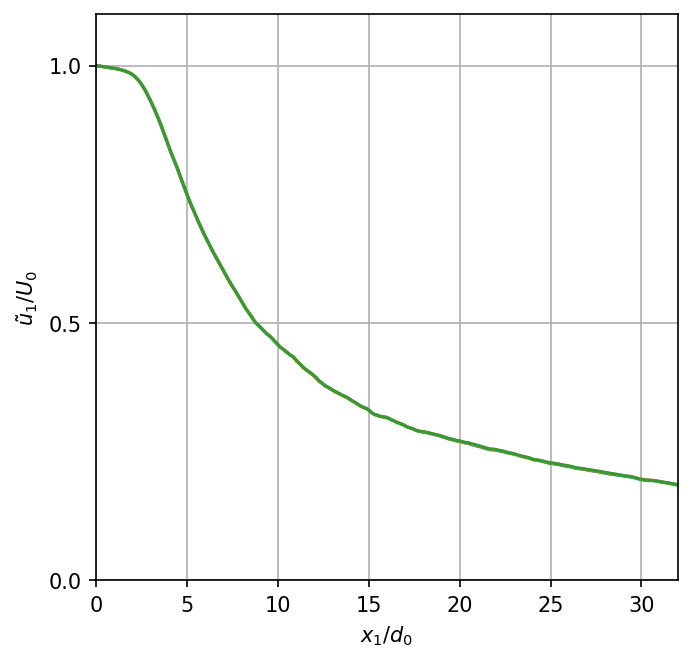

In [6]:
fig = plt.figure(figsize=[5,5], dpi=150)
ax = fig.add_subplot(1, 1, 1)
for _ in range(time_steps):
    ax.plot(X,U[ax_points*_:ax_points*(_+1)])
ax.grid()
ax.set_xlabel('$x_1 / d_0$')
ax.set_ylabel('$\\tilde{u}_1/ {U_0}$')
ax.set_yticks(np.arange(0, 1.25, step=0.5))
plt.axis('tight')
ax.set_ylim([0,1.1])
ax.set_xlim([0,32])
plt.savefig('fig3a.png', dpi=300)

## Figure 3b: Mixture fraction axial variation

(0, 32)

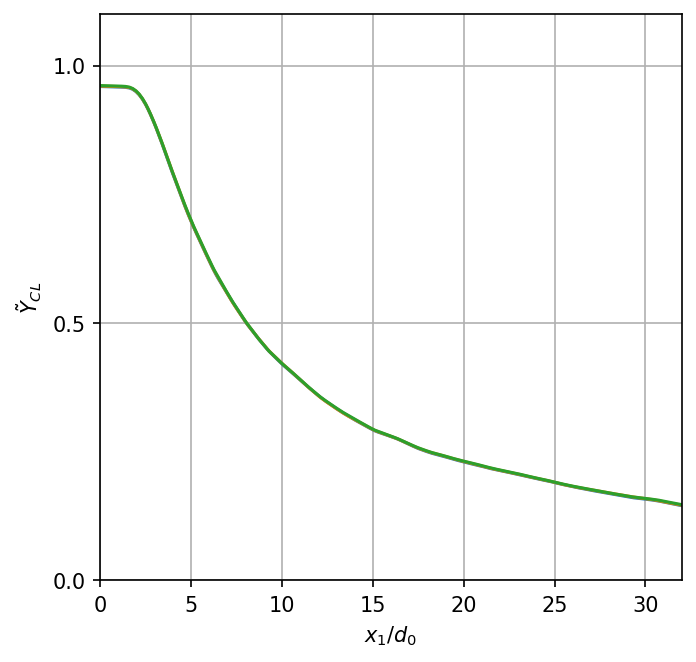

In [8]:
Y = data[:,-13]
fig = plt.figure(figsize=[5,5], dpi=150)
ax = fig.add_subplot(1, 1, 1)
for _ in range(time_steps):
    ax.plot(X,Y[ax_points*_:ax_points*(_+1)])
ax.grid()
ax.set_xlabel('$x_1 / d_0$')
ax.set_ylabel('$\\tilde{Y}_{CL}$')
ax.set_yticks(np.arange(0, 1.25, step=0.5))
plt.axis('tight')
ax.set_ylim([0,1.1])
ax.set_xlim([0,32])
#plt.savefig('fig3b.png', dpi=300)

## Section 3.1 Effective density

## Pipe velocity profile

In [33]:
data = np.loadtxt('pipe_v.dat', skiprows=1)
print(np.shape(data))

(393216, 24)


In [35]:
U = data[:,-19]

# average over ring
U_last = U[int(-len(U)/time_steps):]
U_avg = np.zeros(rd_points)
for i in range(rd_points):
    U_avg[i] = (np.mean(U_last[i*az_points:(i+1)*az_points-1]))
    
X = (np.linspace(0, 0.0055, rd_points))
print('The average velocity is', np.trapz(U_avg*27.7)/(len(U_avg)))

The average velocity is 832.5604461353107


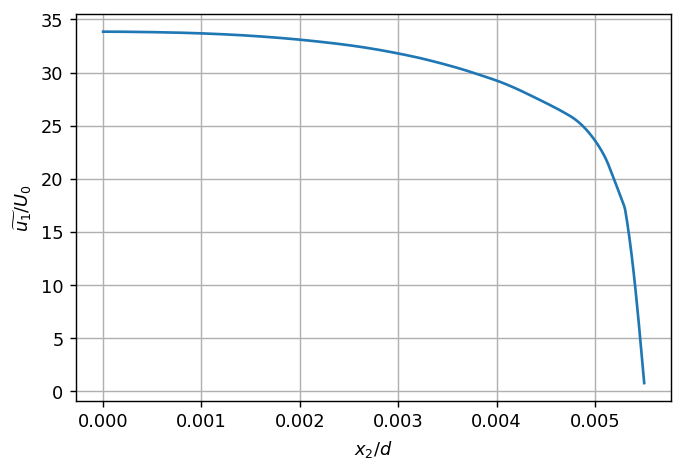

In [46]:
fig = plt.figure(dpi=128)
ax  = fig.add_subplot(1,1,1)
#ax.plot(X, np.flip(U_avg))
ax.plot(X, U_avg)
ax.set_xlabel('$x_2/d$')
ax.set_ylabel('$\widetilde{u_1}/ {U_0}$')
ax.grid()
plt.savefig('ring_avg.png',dpi=300)

## Axial velocity radial variation

In [9]:
data1 = np.loadtxt('fig7_1.dat', skiprows=1)
data2 = np.loadtxt('fig7_2.dat', skiprows=1)
data3 = np.loadtxt('fig7_3.dat', skiprows=1)
data = np.stack(((data1, data2, data3)))
print(np.shape(data))

(3, 196608, 24)


In [10]:
U_avg = np.zeros((3,rd_points))

for j in range(3):
    U = data[j,:,-16]
    U_last = U[-int(len(U)/time_steps):] # extract last timestep data
    for i in range(rd_points):
        U_avg[j,i] = (np.mean(U_last[i*az_points:(i+1)*az_points-1]))   
        
X = (np.linspace(0, 0.265, rd_points))

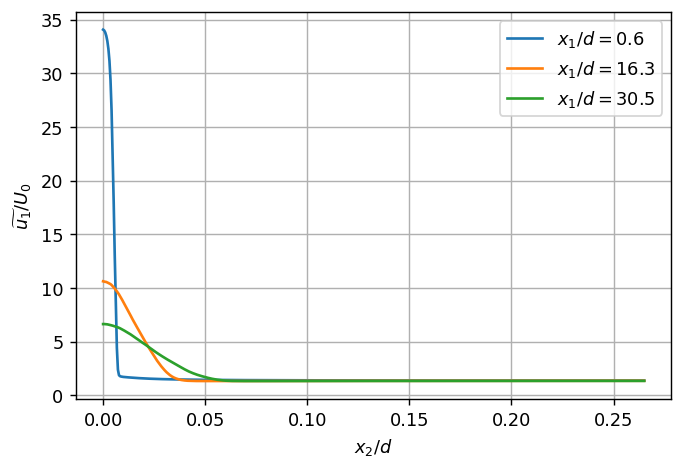

In [11]:
fig = plt.figure(dpi=128)
ax  = fig.add_subplot(1,1,1)
ax.plot(X,np.flip(U_avg[0,:]),label='$x_1/d = 0.6$')  # flip velocity array to align with x
ax.plot(X,np.flip(U_avg[1,:]),label='$x_1/d = 16.3$')
ax.plot(X,np.flip(U_avg[2,:]),label='$x_1/d = 30.5$')
ax.set_xlabel('$x_2/d$')
ax.set_ylabel('$\widetilde{u_1}/ {U_0}$')
#ax.set_xlim([0,5])
ax.grid()
ax.legend()
#plt.savefig('coflow_ring_avg.png',dpi=300)

## Figure 7a: 

The self-similar normalization from Charonko and Presteridge (Figure 7) is used. The scaling for velocity is as follows

$$ \frac{\tilde{u}_1 - \tilde{u}_{\infty}}{\tilde{u}_{1,CL} - \bar{u}_{\infty}} $$

and for length it is $$\frac{x_2}{r_{\tilde{u}_{1/2}}}$$



In [12]:
r_half     = np.zeros(3)
u_fa_infty = np.zeros(3)
u_fa_cl    = np.zeros(3)
u_ra_infty = np.zeros(3)
U_ss       = np.zeros((3,rd_points))
X_ss       = np.zeros((3,rd_points))

for j in range(3):
    r_half[j] = (rd_points - np.argmin(np.abs(U_avg[j,:] - U_avg[j,-1]/2)))/rd_points *.265
    u_fa_infty[j] = U_avg[j,0]
    u_fa_cl[j] = U_avg[j,-1]
    u_ra_infty[j] = u_fa_infty[j] # approximation to avoid loading ra data
    U_ss[j,:] = (U_avg[j,:] - u_fa_infty[j])/(u_fa_cl[j] - u_fa_infty[j])
    X_ss[j,:] = X/r_half[j]

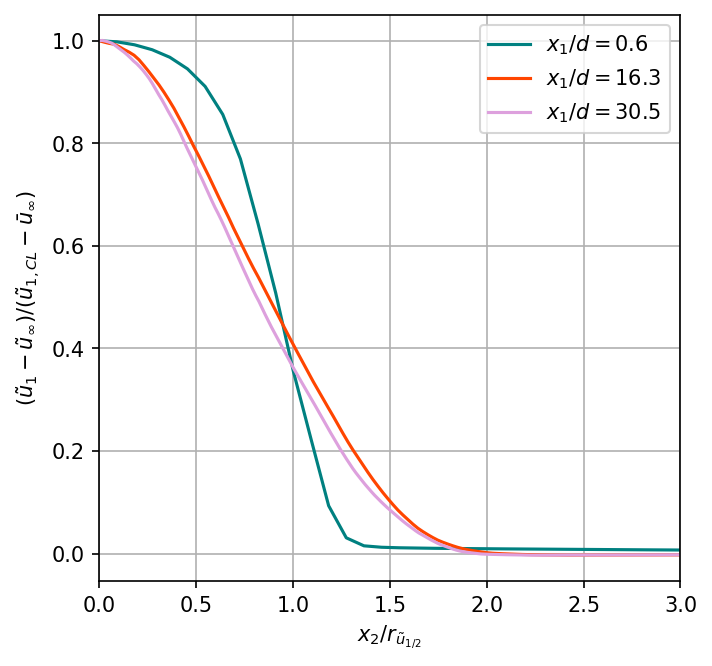

In [13]:
fig = plt.figure(figsize=([5,5]),dpi=150)
ax = fig.add_subplot(1,1,1)
#ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.plot(X_ss[0,:], np.flip(U_ss[0,:]), 'teal', label='$x_1/d = 0.6$')
ax.plot(X_ss[1,:], np.flip(U_ss[1,:]), 'orangered', label='$x_1/d = 16.3$')
ax.plot(X_ss[2,:], np.flip(U_ss[2,:]), 'plum', label='$x_1/d = 30.5$')
ax.set_xlim([0,3])
ax.set_ylabel('$(\\tilde{u}_1 - \\tilde{u}_{\infty})/(\\tilde{u}_{1,CL} - \\bar{u}_{\infty}$)')
ax.set_xlabel('$x_2/r_{\\tilde{u}_{1/2}}$')
#ax.axis('equal')
ax.legend()
ax.grid()
#plt.savefig('fig7a5.png',dpi=300)

## Figure 7b: Radial velocity radial variation

In [14]:
data1 = np.loadtxt('fig7_1.dat', skiprows=1)
data2 = np.loadtxt('fig7_2.dat', skiprows=1)
data3 = np.loadtxt('fig7_3.dat', skiprows=1)
data = np.stack(((data1, data2, data3)))
print(np.shape(data))

(3, 196608, 24)


In [ ]:
U_avg = np.zeros((3,rd_points))

for j in range(3):
    U = data[j,:,-16]
    V = data[j,:,-15]

In [67]:
U_avg = np.zeros((3,rd_points))

for j in range(3):
    U = data[j,:,9]
    U_last = U[-int(len(U)/time_steps):] # extract last timestep data
    for i in range(rd_points):
        U_avg[j,i] = (np.mean(U_last[i*az_points:(i+1)*az_points-1]))   
        
X = (np.linspace(0, 0.265, rd_points))

In [81]:
r_half     = np.zeros(3)
u_fa_infty = np.zeros(3)
u_fa_cl    = np.zeros(3)
u_ra_infty = np.zeros(3)
U_ss       = np.zeros((3,rd_points))
X_ss       = np.zeros((3,rd_points))

for j in range(3):
    r_half[j] = (rd_points - np.argmin(np.abs(U_avg[j,:] - U_avg[j,-1]/2)))/rd_points *.265
    u_fa_infty[j] = U_avg[j,0]
    u_fa_cl[j] = U_avg[j,-1]
    u_ra_infty[j] = u_fa_infty[j] # approximation to avoid loading ra data
    U_ss[j,:] = (U_avg[j,:])/(u_fa_cl[j] - u_fa_infty[j])
    X_ss[j,:] = X/r_half[j]

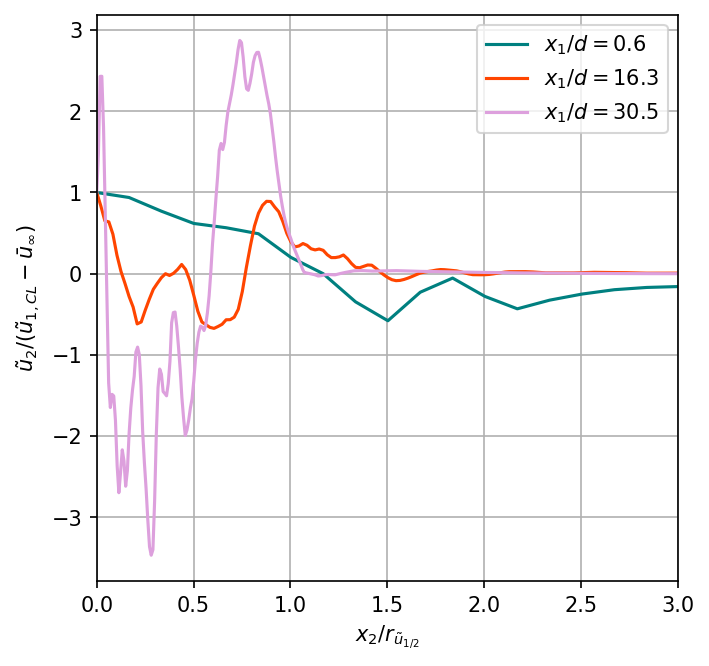

In [82]:
fig = plt.figure(figsize=([5,5]),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.plot(X_ss[0,:], np.flip(U_ss[0,:]), 'teal', label='$x_1/d = 0.6$')
ax.plot(X_ss[1,:], np.flip(U_ss[1,:]), 'orangered', label='$x_1/d = 16.3$')
ax.plot(X_ss[2,:], np.flip(U_ss[2,:]), 'plum', label='$x_1/d = 30.5$')
ax.set_xlim([0,3])
ax.set_ylabel('$\\tilde{u}_2/(\\tilde{u}_{1,CL} - \\bar{u}_{\infty}$)')
ax.set_xlabel('$x_2/r_{\\tilde{u}_{1/2}}$')
ax.legend()
ax.grid()
#plt.savefig('fig7a5.png',dpi=300)

In [3]:
data1 = np.loadtxt('fig7_1.dat', skiprows=1)
data2 = np.loadtxt('fig7_2.dat', skiprows=1)
data3 = np.loadtxt('fig7_3.dat', skiprows=1)
data = np.stack(((data1, data2, data3)))
print(np.shape(data))

(3, 393216, 24)


# Following code is incomplete/incorrect

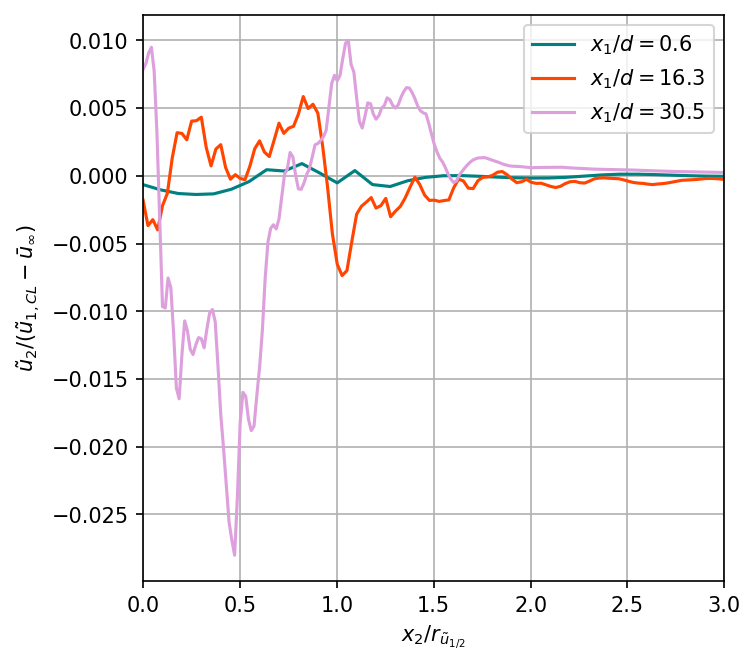

In [17]:
fig = plt.figure(figsize=([5,5]),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.plot(X_ss[0,:], np.flip(Ur_ss[0,:]), 'teal', label='$x_1/d = 0.6$')
ax.plot(X_ss[1,:], np.flip(Ur_ss[1,:]), 'orangered', label='$x_1/d = 16.3$')
ax.plot(X_ss[2,:], np.flip(Ur_ss[2,:]), 'plum', label='$x_1/d = 30.5$')
ax.set_xlim([0,3])
ax.set_ylabel('$\\tilde{u}_2/(\\tilde{u}_{1,CL} - \\bar{u}_{\infty}$)')
ax.set_xlabel('$x_2/r_{\\tilde{u}_{1/2}}$')
ax.legend()
ax.grid()
#plt.savefig('fig7a5.png',dpi=300)

## Figure 10: Radial profiles of axial Reynolds stress (RA)

In [70]:
data1 = np.loadtxt('fig7_1.dat', skiprows=1)
data2 = np.loadtxt('fig7_2.dat', skiprows=1)
data3 = np.loadtxt('fig7_3.dat', skiprows=1)
data = np.stack(((data1, data2, data3)))
print(np.shape(data))

(3, 393216, 24)


In [81]:
U_avg = np.zeros((3,rd_points))
R11 = np.zeros((3,rd_points))

for j in range(3):
    
    U = data[j,:,6]
    U_last = U[-int(len(U)/time_steps):] # extract last timestep data
    for i in range(rd_points):
        U_avg[j,i] = (np.mean(U_last[i*az_points:(i+1)*az_points-1]))  
    
    r11 = data[j,:,-12]
    r11_last = r11[-int(len(r11)/time_steps):] # extract last timestep data
    for i in range(rd_points):
        R11[j,i] = (np.mean(r11_last[i*az_points:(i+1)*az_points-1]))   
        
X = (np.linspace(0, 0.265, rd_points))

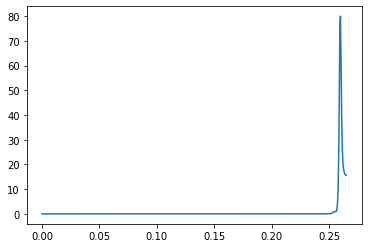

In [82]:
plt.plot(X, R11[0,:])

In [83]:
# rescaling (at CL and infty, RA is assumed to be equal to FA)

r_half     = np.zeros(3)
u_fa_infty = np.zeros(3)
u_fa_cl    = np.zeros(3)
U1_star       = np.zeros((3,rd_points))
X_ss       = np.zeros((3,rd_points))

for j in range(3):
    r_half[j] = (rd_points - np.argmin(np.abs(U_avg[j,:] - U_avg[j,-1]/2)))/rd_points *.265
    u_fa_infty[j] = U_avg[j,0]
    u_fa_cl[j] = U_avg[j,-1]
    U1_star[j,:] = np.sqrt((R11[j,:])/(u_fa_cl[j]**2 - u_fa_infty[j]**2))
    X_ss[j,:] = X/r_half[j]

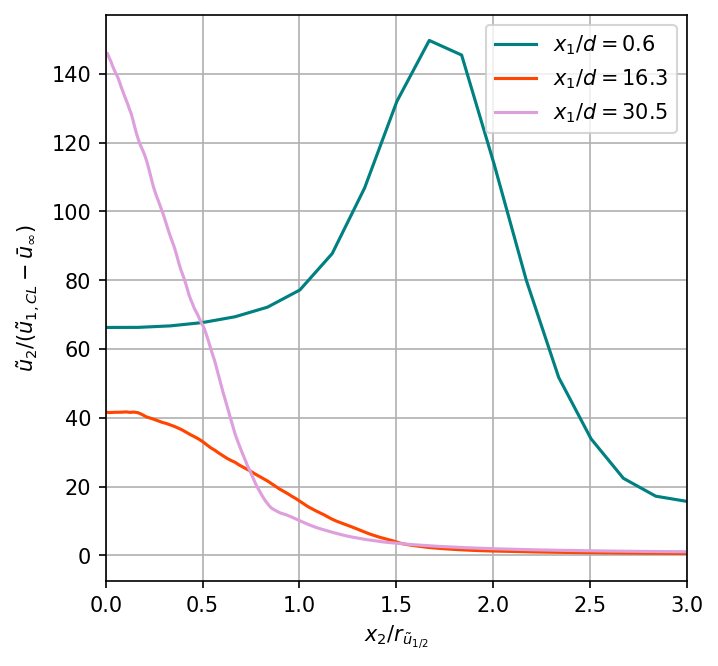

In [84]:
fig = plt.figure(figsize=([5,5]),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.plot(X_ss[0,:], np.flip(U1_star[0,:]), 'teal', label='$x_1/d = 0.6$')
ax.plot(X_ss[1,:], np.flip(U1_star[1,:]), 'orangered', label='$x_1/d = 16.3$')
ax.plot(X_ss[2,:], np.flip(U1_star[2,:]), 'plum', label='$x_1/d = 30.5$')
ax.set_xlim([0,3])
ax.set_ylabel('$\\tilde{u}_2/(\\tilde{u}_{1,CL} - \\bar{u}_{\infty}$)')
ax.set_xlabel('$x_2/r_{\\tilde{u}_{1/2}}$')
ax.legend()
ax.grid()